In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import tellurium as te
from odbm.odbm import ModelBuilder, ModelHandler
import matplotlib.pyplot as plt
from odbm.vis import *
from odbm.utils import extractParams, fmt, getStoich
import itertools


In [2]:
model_species = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Species & Base Mechanisms', engine = 'openpyxl').dropna('index','all')
model_rxns = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Reaction', engine = 'openpyxl').dropna('index','all')

In [3]:
expression_limit = 0.05 
enzyme_ratio = {'Sda':1, 'PCX': 100, 'Mdh': 1}
N_ratios = sum(enzyme_ratio.values())
expression_fudge = 1/10
enzymeInit = {k:expression_limit*expression_fudge/N_ratios*v for k,v in enzyme_ratio.items()}

solubilities = {    'ATP' : 98.619,
                    'Serine': 2380.952,
                    'HCO3' : 1470.588,
                    'NADH' : 150.739 
                }
sol_fudge = 1/20
solubilities = {k:v*sol_fudge for k,v in solubilities.items()}
solubilities['Serine'] = min(solubilities.values())

for k,v in solubilities.items():
    model_species.loc[model_species['Label'] == k,'StartingConc'] = v

# constant_species = ['ATP','NADH']
# # this kind of works
# for s in constant_species:
#     model_species.loc[model_species['Label'] == s,'Label'] = '$'+s

serine_mw = 105.09
malate_mw = 134.0874

In [4]:
N = 100000
init_serine = {'SERINE':10**np.random.uniform(np.log10(solubilities['Serine']/500), np.log10(solubilities['Serine']*2), N)}
#plt.hist(serine.values())

In [10]:
sdaV = list(map(lambda x:x.upper(),model_species[['Sda' in s for s in model_species['Label']]]['Label']))[:4]
pcxV = list(map(lambda x:x.upper(),model_species[['PCX' in s for s in model_species['Label']]]['Label']))[:4]
mdhV = list(map(lambda x:x.upper(),model_species[['Mdh' in s for s in model_species['Label']]]['Label']))[:4]
init_DNA = {}
for i,sda in enumerate(sdaV):
    for j,pcx in enumerate(pcxV):
        for k,mdh in enumerate(mdhV):
            init_DNA['DNA_'+sda] = np.roll(np.append(10**np.random.uniform(np.log10(expression_limit/100), np.log10(expression_limit*10), int(N/len(sdaV))),np.zeros((int(N/len(sdaV))*(len(sdaV)-1)))),int(N/len(sdaV))*(i-1))
            init_DNA['DNA_'+pcx] = np.roll(np.append(10**np.random.uniform(np.log10(expression_limit/100), np.log10(expression_limit*10), int(N/len(pcxV))),np.zeros((int(N/len(pcxV))*(len(pcxV)-1)))),int(N/len(pcxV))*(j-1))
            init_DNA['DNA_'+mdh] = np.roll(np.append(10**np.random.uniform(np.log10(expression_limit/100), np.log10(expression_limit*10), int(N/len(mdhV))),np.zeros((int(N/len(mdhV))*(len(mdhV)-1)))),int(N/len(mdhV))*(k-1))

In [36]:
tau = 4*60*60
taus = {'tau_'+enz:10**np.random.uniform(np.log10(tau/4),np.log10(tau*2.5), N) for enz in [*sdaV,*pcxV,*mdhV]}

In [6]:
fluxes = {'Pyruvate': 12.478089, 'Serine': 1.678, 'Malate': 6.267} #units of mmol/gDW*hr
amounts = {'Pyruvate': 0.39, 'Serine': 0.068, 'Malate': 1.7} #units of mmol/gDW*hr

prot_dilution_factor = 25*100

def convertFlux(fluxes):
    new_fluxes = {}
    for f in fluxes:
        new_fluxes[f] = (fluxes[f]*(3E-13)/(1E-15))/prot_dilution_factor/3600/amounts[f]
    return new_fluxes

new_fluxes = convertFlux(fluxes)

keys = {'Pyruvate': 'k_R14', 'Serine': 'k_R13', 'Malate': 'k_R15'}
siphon = {k:v for k,v in zip([keys[ky] for ky in new_fluxes.keys()], [10**np.random.uniform(np.log10(s/31), np.log10(s*31), N) for s in new_fluxes.values()])}

In [11]:
params = {**siphon,**init_serine, **init_DNA}

In [38]:
modelfile = 'Examples/multi_enzyme_model.txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

model = open(modelfile,'r').read()
r  = te.loada(model)

In [201]:
results_id = np.empty((len(sdaV), len(pcxV), len(mdhV)), dtype=int)
results = []
selections = list(map(fmt, myModel.species['Label'])) + list(myModel.rxns['Label']) + ['time']

count = 0
for i,sda in enumerate(sdaV):
    for j,pcx in enumerate(pcxV):
        for k,mdh in enumerate(mdhV):
            r.resetAll()
            r['SERINE'] = 3
            r['k_R13'] = new_fluxes['Serine']
            r['k_R14'] = 0
            r['k_R15'] = 0
            r['k_TXTL'] = expression_limit/8/20*10e6/3600


            r['DNA_'+sda] = 1/10e6
            r['DNA_'+pcx] = 1/10e6
            r['DNA_'+mdh] = 1/10e6
            results_id[i,j,k] = count
            results.append(r.simulate(0,24*60*60,1000, selections=selections))
            count += 1

(array([16.,  0., 32.,  0.,  0.,  0.,  0.,  0.,  0., 16.]),
 array([0.21589608, 0.27062646, 0.32535684, 0.38008722, 0.4348176 ,
        0.48954798, 0.54427836, 0.59900874, 0.65373911, 0.70846949,
        0.76319987]),
 <BarContainer object of 10 artists>)

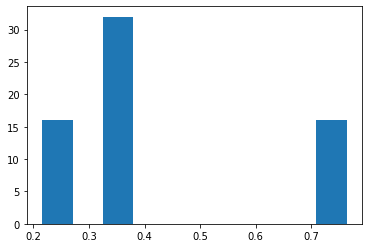

In [202]:
plt.hist([sum([r[v][-1] for v in [*sdaV,*pcxV,*mdhV]])/0.05*100 for r in results])

(array([16.,  0.,  0.,  0.,  0.,  0.,  0., 32.,  0., 16.]),
 array([ 760.48295133,  797.44649135,  834.41003137,  871.37357138,
         908.3371114 ,  945.30065142,  982.26419143, 1019.22773145,
        1056.19127147, 1093.15481148, 1130.1183515 ]),
 <BarContainer object of 10 artists>)

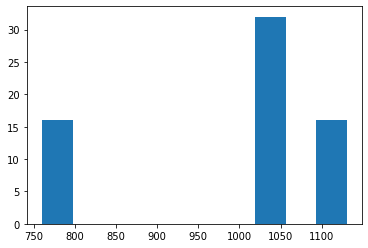

In [203]:
plt.hist([max(r['MALICACID'])*malate_mw/(r['SERINE'][0]*serine_mw)*1000 for r in results])

3.5982704371897786e-05

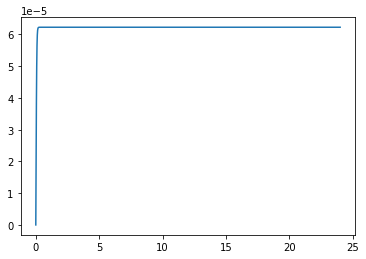

In [204]:
plt.plot(results[0]['time']/60/60,results[32][sdaV[2]])
results[0][pcxV[0]][-1]

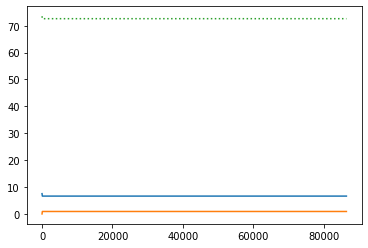

In [42]:
df = pd.DataFrame(results[0], columns = results[0].colnames)
df.round(2)
plt.plot(df['time'],df['NADH'],  label = 'NADH')
plt.plot(df['time'],df['ADP'], label = 'ADP')
plt.plot(df['time'],df['HCO3'],  linestyle = 'dotted', label = 'CO2')

#plt.xlim(0, 100)
#plt.ylim(0,200)


[(0.0, 300.0), (0.0, 300.0), (0.0, 300.0)]

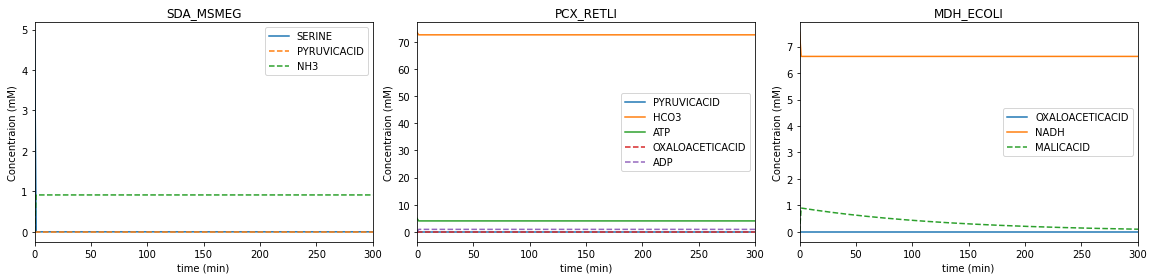

In [43]:
variants = (0,0,0) #define combination of variants to plot
v_labels = [v[k] for v,k in zip([sdaV, pcxV, mdhV], variants)] #get variant names
run = int(results_id[variants]) #return simulation run  # in which that combination was tested
rxn_idx = [int(variants[0]),int(variants[1]+4), int(variants[2]+8)] #brute force method of getting reaction index for each variant
f, ax = rxn_plot(myModel, results[run], rxn_idx, figsize=(16,4), titles = v_labels)
[a.set_xlim([0,300]) for a in ax]

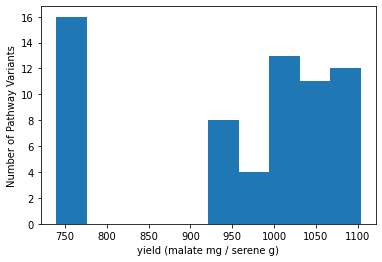

In [57]:
plt.hist([((max(r['MALICACID'])*malate_mw)/(r['SERINE'][0]*serine_mw)*1000) for r in results]);
plt.xlabel('yield (malate mg / serene g)');
plt.ylabel('Number of Pathway Variants');

(0.0, 200.0)

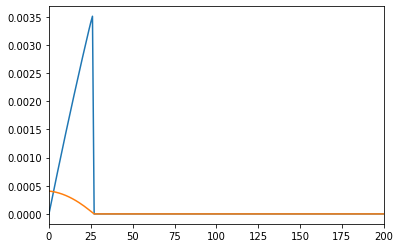

In [60]:
plt.plot(results[0]['R1'])
plt.plot(results[0]['R13'])

plt.xlim([0,200])


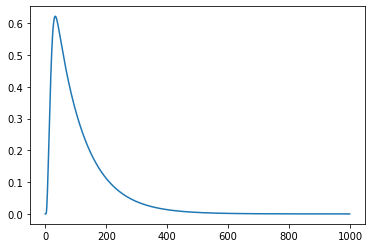

In [11]:
plt.plot(results[0]['MALICACID'])

In [12]:
modelfile = 'Examples/multi_enzyme_model.txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

model = open(modelfile,'r').read()
MH = ModelHandler(model)

selections = list(map(fmt, myModel.species['Label'])) + list(myModel.rxns['Label']) + ['time']
MH.setSimParams(0,24*60*60,200, selections=selections)

MH.setParameterScan(params)
yld = lambda x: ((max(x['MALICACID'])*malate_mw)/(x['SERINE'][0]*serine_mw)*1000)


In [11]:
res = MH.sensitivityAnalysis()

In [15]:
ylds = np.array(list(map(yld,res)))

(array([137.,  61.,  38.,  15.,  11.,   4.,   5.,   2.,   2.,   1.]),
 array([200.17535389, 262.96681676, 325.75827963, 388.5497425 ,
        451.34120537, 514.13266825, 576.92413112, 639.71559399,
        702.50705686, 765.29851973, 828.0899826 ]),
 <BarContainer object of 10 artists>)

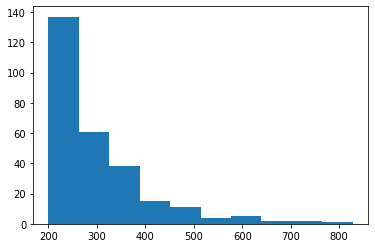

In [18]:
plt.hist(ylds[ylds>200])

In [80]:
pd.DataFrame({**params,'yld':ylds}).corr()['yld']

NameError: name 'ylds' is not defined

In [13]:
pd.DataFrame(params)[pd.DataFrame(params)>0].max()/pd.DataFrame(params)[pd.DataFrame(params)>0].min()

k_R14             960.969969
k_R13             960.882765
k_R15             960.976014
SERINE            999.808333
DNA_SDA_MSMEG     998.904160
DNA_PCX_RETLI     999.775035
DNA_MDH_ECOLI     998.988728
DNA_MDH_MDOM      999.858128
DNA_MDH_REMER     999.523782
DNA_MDH_TAES      999.652582
DNA_PCX_SCER      999.158873
DNA_PCX_MSMEG     999.152753
DNA_PCX_GTHERM    999.276949
DNA_SDA_BSUB      998.942758
DNA_SDA_ECOLI     999.339665
DNA_SDA_LPNEU     999.022972
dtype: float64

<AxesSubplot:>

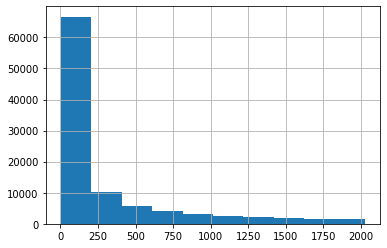

In [14]:
(0.2/pd.DataFrame(params)['SERINE']*100).hist()

In [127]:
sum(pd.DataFrame(params)['SERINE']>0.2)

56346